<a href="https://colab.research.google.com/github/harinath0906/Bingi-s-Projects/blob/master/COMP5329_Ass2_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5329 Assignment 2

- 460390611
- 470331161
- 490619580

# Import Libraries

In [0]:
# Data process
import pandas as pd
import numpy as np

# Graphing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Image loading
from PIL import Image
import glob
from numpy import asarray

# Output
from sys import stdout
import csv
import copy
from random import seed
from random import randint
import random
import time
import datetime
import zipfile
#from tqdm import tqdm

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import torch.utils.model_zoo as model_zoo

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH_TO_CODE_FOLDER = "/content/drive/My Drive/Code"


BATCH_SIZE = 128
NUM_EPOCHS = 20
PERCENTILE = 99 #99.7
LEARNING_RATE = 0.0001
#DISABLE_TQDM = True
RESNET50_MODEL_URL = 'https://download.pytorch.org/models/resnet50-19c8e357.pth'

In [0]:
pd.set_option('display.max_colwidth', -1)
if (not PATH_TO_CODE_FOLDER.endswith('/')):
    PATH_TO_CODE_FOLDER+="/"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


# 2. LOAD DATA

### Load Training Data

In [0]:
train_file = open(PATH_TO_CODE_FOLDER+'input/train.csv',"r+").read()
colnames = train_file.split("\n")[0]

traindata_lines =  train_file.split(colnames)[1].split("\"\n")
train=pd.DataFrame(columns=colnames.split(","))


for idx in range(len(traindata_lines)):
    if traindata_lines[idx].strip() == "":
        continue
    templist = []
    try:
        index1 = traindata_lines[idx].index(",")
        index2 = traindata_lines[idx].index(",\"")
    except:
        print("skipping",traindata_lines[idx])
    templist.append(traindata_lines[idx][0:index1].strip())
    templist.append(traindata_lines[idx][index1+1:index2])
    templist.append(traindata_lines[idx][index2+1:len(traindata_lines)].strip("\""))
    train.loc[len(train)]=templist


### Load Test Data

In [0]:
test_file = open(PATH_TO_CODE_FOLDER+'input/test.csv',"r+")  
  
testdata_lines =  test_file.read().split("\n")


test=pd.DataFrame(columns=testdata_lines[0].split(","))


for i in range(1,len(testdata_lines)):
    if testdata_lines[i].strip() == "":
        continue
    templist = []
    eachline = testdata_lines[i].split(",\"")
    try:
        templist.append(eachline[0].strip())
        templist.append(eachline[1].strip("\""))
    except:
        print(eachline)
    test.loc[len(test)]=templist
    

In [0]:
print("Train")
print(train.iloc[5:15])
print(train.shape)

print("Test")
print(test.iloc[5:15])
print(test.shape)

Train
   ImageID  ...                                                             Caption
5   5.jpg   ...  A young man riding a skateboard into the air.                     
6   6.jpg   ...  A big airplane flying in the big blue sky                         
7   7.jpg   ...  A man riding a motor bike across a forest.                        
8   8.jpg   ...  There is a street lined with packed buildings                     
9   9.jpg   ...  A skate park next to a body of water and green park.              
10  10.jpg  ...  Woman cutting pizza with fork and knife sitting next to young girl
11  11.jpg  ...  a man and woman cut into a big cake                               
12  12.jpg  ...  A piece of cake and coffee are on an outdoor table.               
13  13.jpg  ...  People gathered outside in a big field on a cloudy day            
14  14.jpg  ...  A stop sign directs pedestrians as a train travels by.            

[10 rows x 3 columns]
(30000, 3)
Test
      ImageID                  

### Load Images into Tensors

In [0]:
print("Loading images: ")

# Load images from directory
#images = glob.glob(PATH_TO_CODE_FOLDER+'input/data' + '/*.jpg')


image_dict = {} # Stores values with the filename as the key


with zipfile.ZipFile(PATH_TO_CODE_FOLDER+'input/2020s1comp5329assignment2.zip') as archive:
    images_len = len(archive.infolist())
    print(images_len)
    images_load = images_len/100
    load_count = 0 # 1-100
    image_count = 0 # 1-40,000
    for entry in archive.infolist():
        if entry.filename.lower().endswith(".jpg"):            
            with archive.open(entry) as file:
                #print(file)
                pic = Image.open(file)
                #print(img.size, img.mode, len(img.getdata()))
                pic_values = asarray(pic) # convert image to array of values
                tempname = entry.filename.replace("/","\\").split("\\")
                key = tempname[len(tempname)-1]
                image_dict[key] = pic_values
                if (image_count % images_load == 0):
                    load_count += 1
                    stdout.write("\r%d" % load_count)
                    stdout.write("%")
                    stdout.flush()
                image_count += 1

print("\nImages loaded :",len(image_dict))

Loading images: 
40002
1%
Images loaded : 40000


0.jpg
1.jpg
10.jpg
100.jpg
1000.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg
10009.jpg


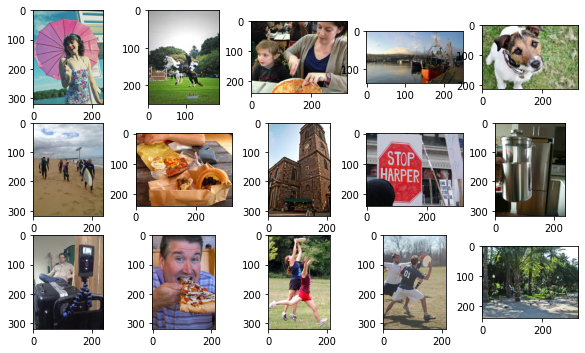

In [0]:
# TEST HOW THE IMAGES LOOK

count = 0
plt.figure(figsize=(10,10))
for k in image_dict.keys():
  if count >= 15:
    break
  count += 1
  print(k)

  plt.subplot(5,5,count)
  plt.imshow(image_dict[k], cmap=plt.cm.binary)

  #plt.show(Image.fromarray(image_dict[k]))
  plt.grid(False)
plt.show()

In [0]:
data_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])

In [0]:
all_single_labels= []
all_single_labels += [int(x) for lst in [eachlab.split(" ") for eachlab in train.Labels] for x in lst] 
unique_labels = np.unique(all_single_labels)
print(unique_labels)
#print(len(unique_labels))

#output_dim =max(unique_labels)+1
#print(output_dim)

label_to_index = {n: i for i, n in enumerate(unique_labels)}
index_to_label = {i: n for i, n in enumerate(unique_labels)}
#print(index_to_label)
#print(label_to_index)
output_dim = len(label_to_index)
print("Number of unique labels :",output_dim)

[ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19]
Number of unique labels : 18


In [0]:
seed=27

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [0]:


from torch.utils import data
class ImageData(data.Dataset):
    def __init__(self,df,dirpath,transform,test = False):
        self.df = df
        self.test = test
        self.dirpath = dirpath
        self.conv_to_tensor = transform
        self.image_arr = self.df.iloc[:, 0] #np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        #image data 
        #if not self.test:
         #   self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0]+'.png')
        #else:
         #   self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        
        #labels data
        if not self.test:
             self.label_df = self.df.iloc[:,1]
             #print(self.label_df)
        # Calculate length of df
        self.data_len = len(self.df.index)

    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        image_name = self.image_arr[idx]
        #img = Image.open(image_name)
        img_tensor = self.conv_to_tensor(Image.fromarray(image_dict[image_name])) #self.conv_to_tensor(img) Image.fromarray(np.uint8(cm.gist_earth(myarray)*255))
        if not self.test:
            image_labels = self.label_df[idx]
            #print(self.label_df[idx])
            label_tensor = torch.zeros((1, output_dim))
            for label in image_labels.split():
                label_tensor[0, label_to_index[int(label)]] = 1  #converting lavel to index of label
            image_label = torch.tensor(label_tensor,dtype= torch.float32)
            #print(image_label)
            return (img_tensor,image_label.squeeze())
        return (img_tensor)



In [0]:
#df = pd.read_csv(train_csv)
# if you want to run on less data to quickly check
#df = pd.read_csv(train_csv).head(5000)
from sklearn.model_selection import train_test_split
train_df,val_df = train_test_split(train, test_size=0.20)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print(f"Validation_Data Length: {len(val_df)}\nTrain_Data Length: {len(train_df)}")

Validation_Data Length: 6000
Train_Data Length: 24000


In [0]:


# Train dataset
train_dataset = ImageData(train_df,PATH_TO_CODE_FOLDER+'input/data',data_transforms)
train_loader = data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=False)

# validation dataset
val_dataset = ImageData(val_df,PATH_TO_CODE_FOLDER+'input/data',data_transforms)
val_loader = data.DataLoader(dataset=val_dataset,batch_size=BATCH_SIZE,shuffle=False)

# test dataset
test_dataset = ImageData(test,PATH_TO_CODE_FOLDER+'input/data',data_transforms,test = True)
test_loader = data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

dataloaders_dict = {'train':train_loader, 'val':val_loader}



### Model Build

In [0]:
#resnet_weights_path = PATH_TO_CODE_FOLDER+"algorithm/resnet50-19c8e357.pth"

resnet_cls = models.resnet50()
state_dict = model_zoo.load_url(RESNET50_MODEL_URL)
#state_dict = update_state_dict(state_dict)
#model.load_state_dict(state_dict)
#resnet_cls.load_state_dict(torch.load(resnet_weights_path))
resnet_cls.load_state_dict(state_dict)



class AvgPool(nn.Module):
    def forward(self, x):
        return F.avg_pool2d(x, x.shape[2:])
    
class ResNet50(nn.Module):
    def __init__(self,num_outputs):
        #print("in resnet inti")
        super(ResNet50,self).__init__()
        self.resnet = resnet_cls
        layer4 = self.resnet.layer4
        self.resnet.layer4 = nn.Sequential(
                                    nn.Dropout(0.5),
                                    layer4
                                    )
        self.resnet.avgpool = AvgPool()
        self.resnet.fc = nn.Linear(2048, num_outputs)
        for param in self.resnet.parameters():
            param.requires_grad = False

        for param in self.resnet.layer4.parameters():
            param.requires_grad = True

        for param in self.resnet.fc.parameters():
            param.requires_grad = True
        #print("after resnet init")
            
    def forward(self,x):
        out = self.resnet(x)
        return out
    
NeuralNet = ResNet50(num_outputs = output_dim) 

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Function for f1-score validation

In [0]:
from sklearn.metrics import f1_score
def cal_f1score(pred_labels, output_labels):
    #i = 0
#for test_batch in test_loader:
    #output_labels_np = output_labels.detach().cpu().numpy()
    #predictions_np = pred_labels.detach().cpu().numpy()
    #test_batch = test_batch.to(device)
    #batch_prediction = NeuralNet(test_batch).detach().cpu().numpy()
    #predictions[i * BATCH_SIZE:(i+1) * BATCH_SIZE, :] = batch_prediction
    pred_labels_np = []
    for i in range(len(pred_labels)):         
        idx_list = np.where(pred_labels[i] > np.percentile(pred_labels[i],PERCENTILE))
        temp = np.zeros(output_dim)
        for eachidx in idx_list:
            temp[eachidx] = 1
        pred_labels_np.append(temp.tolist())
    #print(output_labels)
    #print(pred_labels_np)
    return f1_score(y_true=output_labels, y_pred=pred_labels_np, average='weighted')


### Train Model

In [0]:
NeuralNet = NeuralNet.to(device)
optimizer = optim.Adam(NeuralNet.parameters(),lr = LEARNING_RATE)
loss_func = torch.nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 2)
best_f1 = np.NINF

starttime = datetime.datetime.now()
print("Training started @ "+starttime.strftime("%d-%m-%Y %H:%M:%S"))

for epoch in range(NUM_EPOCHS):
    #for phase in ['train', 'val']:
        start_time = time.time()
        NeuralNet.train()
        #if phase == 'train':
            
        #else:
         #   
            
        running_loss = 0.0
        #print(len(dataloaders_dict[phase]))
        counter = 0
        all_output_labels = []
        all_preds = []
        for images_batch, labels_batch in dataloaders_dict['train']:#tqdm(dataloaders_dict[phase],disable = True):
            #print("in for loop")
            all_output_labels.extend(labels_batch.numpy().tolist())
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                pred_batch = NeuralNet(images_batch)
                #print(pred_batch.detach().cpu().numpy().tolist())
                all_preds.extend(pred_batch.detach().cpu().numpy().tolist())
                #print(pred_batch)
                #print(labels_batch)
                loss = loss_func(pred_batch,labels_batch)
            #print("after train")    
            #if phase == 'train':
            loss.backward()
            optimizer.step()
                #print("after back")    
            running_loss += loss.item() * images_batch.size(0)
            #print("Training : Batch",counter+1,"of",len(dataloaders_dict['train']),"Loss:",loss.item()) #TobeRemoved
            counter+=1
        train_f1_score = cal_f1score(all_preds, all_output_labels)
        trian_epoch_loss = running_loss / len(dataloaders_dict['train'].dataset)
        
        
        
        
        NeuralNet.eval()
        running_loss = 0.0
        #print(len(dataloaders_dict[phase]))
        counter = 0
        all_output_labels = []
        all_preds = []
        for images_batch, labels_batch in dataloaders_dict['val']:#tqdm(dataloaders_dict[phase],disable = True):
            #print("in for loop")
            all_output_labels.extend(labels_batch.numpy().tolist())
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(False):
                pred_batch = NeuralNet(images_batch)
                all_preds.extend(pred_batch.detach().cpu().numpy().tolist())
                loss = loss_func(pred_batch,labels_batch)    
            running_loss += loss.item() * images_batch.size(0)
            #print("Validation : Batch",counter+1,"of",len(dataloaders_dict['val']),"Loss:",loss.item()) #TobeRemoved
            counter+=1
        val_epoch_loss = running_loss / len(dataloaders_dict['val'].dataset)
        val_f1_score = cal_f1score(all_preds, all_output_labels)
        if val_f1_score > best_f1:            
            print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_f1_score))
            best_f1 = val_f1_score
            best_model_wts = copy.deepcopy(NeuralNet.state_dict())
        scheduler.step(val_epoch_loss)
        
        
            
        
        elapsed_time = time.time()-start_time
        print("Epoch: {}/{} | Training loss:{:.8f} | Validation loss:{:.8f} | Training f1:{:.8f} | Validation f1:{:.8f} | Time: {:.4f}s".format(epoch+1,
                                                                              NUM_EPOCHS,trian_epoch_loss,val_epoch_loss,train_f1_score,val_f1_score,elapsed_time))
endtime = datetime.datetime.now()
print("Training ended @ "+endtime.strftime("%d-%m-%Y %H:%M:%S"))
print("Time taken for training :",endtime-starttime)
NeuralNet.load_state_dict(best_model_wts)

Training started @ 12-05-2020 13:33:01


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.68282755
Epoch: 1/20 | Training loss:0.15046894 | Validation loss:0.09462930 | Training f1:0.62018327 | Validation f1:0.68282755 | Time: 340.1342s
Info : model f1-score Improved from 0.68282755 to 0.69333603
Epoch: 2/20 | Training loss:0.08599569 | Validation loss:0.08845338 | Training f1:0.69416744 | Validation f1:0.69333603 | Time: 341.1226s
Epoch: 3/20 | Training loss:0.07135773 | Validation loss:0.08898360 | Training f1:0.71549034 | Validation f1:0.69311054 | Time: 339.3586s
Info : model f1-score Improved from 0.69333603 to 0.69400027
Epoch: 4/20 | Training loss:0.05863301 | Validation loss:0.09235479 | Training f1:0.73056202 | Validation f1:0.69400027 | Time: 340.6755s
Epoch: 5/20 | Training loss:0.04716760 | Validation loss:0.10011901 | Training f1:0.73974048 | Validation f1:0.68393591 | Time: 339.0729s
Info : model f1-score Improved from 0.69400027 to 0.69673353
Epoch: 6/20 | Training loss:0.03465963 | Validation loss:0.09115441 | Tr

<All keys matched successfully>

### Save Model

In [0]:
ModelName = "ImageClassification-"+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")+".pt"
path = PATH_TO_CODE_FOLDER+"algorithm/"+ModelName 
torch.save(NeuralNet, path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ResNet50. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type AvgPool. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Generate Predictions

In [0]:
NeuralNet.eval()
predictions = np.zeros((len(test_dataset), output_dim))
i = 0
for test_batch in test_loader:
    test_batch = test_batch.to(device)
    batch_prediction = NeuralNet(test_batch).detach().cpu().numpy()
    predictions[i * BATCH_SIZE:(i+1) * BATCH_SIZE, :] = batch_prediction
    i+=1

In [0]:
predicted_class_idx = []
for i in range(len(predictions)):         
    idx_list = np.where(predictions[i] > np.percentile(predictions[i],PERCENTILE))
    label_list = [index_to_label[y] for y in idx_list[0]]  #converting index to labels
    predicted_class_idx.append(label_list)

In [0]:
test['Labels'] = predicted_class_idx
test['Labels'] = test['Labels'].apply(lambda x : ' '.join(map(str,list(x))))
#test_df = test_df.rename(columns={0: 'id'})
#test_df['id'] = test_df['id'].apply(lambda x : x.split('.')[0])
test.head()

,ImageID,Caption,Labels
0,30000.jpg,A little girl waring a krispy kreme hat holding a box of krispy kreme donuts.,1
1,30001.jpg,A beautiful young woman holding an orange frisbee.,1
2,30002.jpg,A group of people sitting on couch next to a coffee table.,1
3,30003.jpg,A person on a snowboard rides on the hill.,1
4,30004.jpg,A man riding a skateboard with a helmet on in between cones.,1


### Save Predictions

In [0]:
test_tosubmit = test.drop("Caption",1)
#test_tosubmit = test_tosubmit.drop("attribute_ids",1)

In [0]:
test_tosubmit.head()

,ImageID,Labels
0,30000.jpg,1
1,30001.jpg,1
2,30002.jpg,1
3,30003.jpg,1
4,30004.jpg,1


In [0]:
test_tosubmit.to_csv(PATH_TO_CODE_FOLDER +'output/Predicted_labels'+datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")+'.txt',index = False)

### Cells only for displaying details

In [0]:
NeuralNet

ResNet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [0]:
print("TRAINING")
print("training examples: ",len(train_dataset))
print("batch size: ",BATCH_SIZE)
print("batches available: ",len(train_loader))
print()
print("VALIDATION")
print("validation examples: ",len(val_dataset))
print("batch size: ",BATCH_SIZE)
print("batches available: ",len(val_loader))
print()
print("TESTING")
print("testing examples: ",len(test_dataset))
print("batch size: ",BATCH_SIZE)
print("batches available: ",len(test_loader))

TRAINING
training examples:  24000
batch size:  128
batches available:  188

VALIDATION
validation examples:  6000
batch size:  128
batches available:  47

TESTING
testing examples:  10000
batch size:  128
batches available:  79


In [0]:
total_params = sum(p.numel() for p in NeuralNet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in NeuralNet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

23,544,914 total parameters.
15,001,618 training parameters.


In [0]:
features, labels = next(iter(train_loader))
print(f'Train Features: {features.shape}\nTrain Labels: {labels.shape}')
print()
features, labels = next(iter(val_loader))
print(f'Validation Features: {features.shape}\nValidation Labels: {labels.shape}')
print()
features = next(iter(test_loader))
print(f'Test Features: {features.shape}\n')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train Features: torch.Size([128, 3, 224, 224])
Train Labels: torch.Size([128, 18])

Validation Features: torch.Size([128, 3, 224, 224])
Validation Labels: torch.Size([128, 18])

Test Features: torch.Size([128, 3, 224, 224])

